In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time
import datetime
import sqlite3

In [2]:
df_admis= pd.read_csv('~/Downloads/ADMISSIONS.CSV')

In [3]:
df_admis.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [4]:
df_admis.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA'],
      dtype='object')

In [5]:
#CONVERTING TO DATETIME FORMAT
df_admis.ADMITTIME=pd.to_datetime(df_admis.ADMITTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_admis.DISCHTIME=pd.to_datetime(df_admis.DISCHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_admis.DEATHTIME=pd.to_datetime(df_admis.DEATHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

In [6]:
#CHECKING FOR MISSING DATA
print("Missing data in Admissions=",df_admis.ADMITTIME.isnull().sum())
print("Missing data in discharges=",df_admis.DISCHTIME.isnull().sum())

Missing data in Admissions= 0
Missing data in discharges= 0


In [7]:
#REMOVING NEWBORNS
#df_admis = df_admis.loc[df_admis.ADMISSION_TYPE != 'NEWBORN']
#df_admis.groupby(['ADMISSION_TYPE']).size()

In [8]:
#REMOVING DEAD PATIENTS
#df_admis = df_admis.loc[df_admis.DEATHTIME.isnull()]
#RECHECKING
#print('Total rows in dataframe:', len(df_admis))
#print('Non-death admissions:', df_admis.DEATHTIME.isnull().sum())

In [9]:
#EXPLORING DATATYPES
#print(df_admis.ADMITTIME.dtypes)
#print(df_admis.DISCHTIME.dtypes)
#print(df_admis.DEATHTIME.dtypes)

In [10]:
#SORT THE SUBJECT_ID, ADMISSION_DATE
df_admis = df_admis.sort_values(['SUBJECT_ID','ADMITTIME'])
df_admis = df_admis.reset_index(drop = True)

In [11]:
df_admis['NEXT_ADMITTIME']=df_admis.groupby('SUBJECT_ID').ADMITTIME.shift(-1)
df_admis['NEXT_ADMISSION_TYPE']=df_admis.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)

In [12]:
#REPLACING ROWS WITH ELECTIVE ADMISSIONS
rows = df_admis.NEXT_ADMISSION_TYPE == 'ELECTIVE'
df_admis.loc[rows,'NEXT_ADMITTIME'] = pd.NaT
df_admis.loc[rows,'NEXT_ADMISSION_TYPE'] = np.NaN

In [13]:
#SORT BY ADMISSION DATE & SUBJECT ID
df_admis= df_admis.sort_values(['SUBJECT_ID','ADMITTIME'])
df_admis[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']] = df_admis.groupby(['SUBJECT_ID'])[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']].fillna(method = 'bfill')


In [14]:
df_admis['DAYS_UNTILL_NEXT_ADMIT']=  (df_admis.NEXT_ADMITTIME - df_admis.DISCHTIME).dt.total_seconds()/(24*60*60)


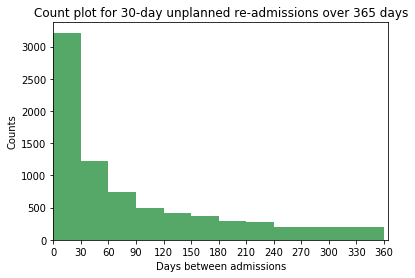

In [15]:
#DAYS BETWEEN READMISSION
plt.hist(df_admis.loc[~df_admis.DAYS_UNTILL_NEXT_ADMIT.isnull(),'DAYS_UNTILL_NEXT_ADMIT'], bins =range(0,365,30),color='#55a868')
plt.xlim([0,365])
plt.xlabel('Days between admissions')
plt.ylabel('Counts')
plt.xticks(np.arange(0, 365, 30))
plt.title('Count plot for 30-day unplanned re-admissions over 365 days')
plt.show()

In [16]:
print('Number with a readmission:', (~df_admis.DAYS_UNTILL_NEXT_ADMIT.isnull()).sum())
print('Total Number of admissions:', len(df_admis))

Number with a readmission: 11399
Total Number of admissions: 58976


In [17]:
df_new = df_admis[['SUBJECT_ID','HADM_ID','ADMITTIME','DISCHTIME','DAYS_UNTILL_NEXT_ADMIT','NEXT_ADMITTIME','ETHNICITY','ADMISSION_TYPE','DEATHTIME','DIAGNOSIS']]
df_new['DEATHTIME'].notnull().value_counts()
df_new = df_new[df_new['DEATHTIME'].isnull()]
df_new['READMISSION'] = np.where(df_new['DAYS_UNTILL_NEXT_ADMIT']< 30, '1', '0')
data=df_new[['SUBJECT_ID','HADM_ID','ADMITTIME','ADMISSION_TYPE','ETHNICITY','DIAGNOSIS','READMISSION']]

In [18]:
data.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,ADMISSION_TYPE,ETHNICITY,DIAGNOSIS,READMISSION
0,2,163353,2138-07-17 19:04:00,NEWBORN,ASIAN,NEWBORN,0
1,3,145834,2101-10-20 19:08:00,EMERGENCY,WHITE,HYPOTENSION,0
2,4,185777,2191-03-16 00:28:00,EMERGENCY,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0
3,5,178980,2103-02-02 04:31:00,NEWBORN,ASIAN,NEWBORN,0
4,6,107064,2175-05-30 07:15:00,ELECTIVE,WHITE,CHRONIC RENAL FAILURE/SDA,0


In [19]:
data = data.loc[data.ADMISSION_TYPE != 'NEWBORN'].copy()
data['READMISSION'].value_counts()

0    42358
1     2963
Name: READMISSION, dtype: int64

In [20]:
#COMPRESSING ETHENCITY CATEGORIES
data['ETHNICITY'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
data['ETHNICITY'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
data['ETHNICITY'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
data['ETHNICITY'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
data['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER','UNKNOWN/NOT SPECIFIED'], value='OTHER/UNKNOWN', inplace=True)
data['ETHNICITY'].loc[~data['ETHNICITY'].isin(data['ETHNICITY'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'
data['ETHNICITY'].value_counts()

/Users/harikapolaki/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


WHITE                     32501
OTHER/UNKNOWN              5640
BLACK/AFRICAN AMERICAN     4471
HISPANIC/LATINO            1625
ASIAN                      1084
Name: ETHNICITY, dtype: int64

In [21]:
#IMPORTING DIAGNOSIS_ICD TABLE
df_diag=pd.read_csv('~/Downloads/DIAGNOSES_ICD.CSV')
print('There are {} unique ICD9 codes in this dataset.'.format(df_diag['ICD9_CODE'].value_counts().count()))

There are 6984 unique ICD9 codes in this dataset.


In [22]:
#FILTERING OUT E AND V CODES
df_diag['recode'] = df_diag['ICD9_CODE']
df_diag['recode'] = df_diag['recode'][~df_diag['recode'].str.contains("[a-zA-Z]").fillna(False)]
df_diag['recode'].fillna(value='999', inplace=True)
df_diag['recode'] = df_diag['recode'].str.slice(start=0, stop=3, step=1)
df_diag[['recode']] = df_diag[['recode']].apply(pd.to_numeric)

#ICD9 CATEGORIES
icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390),
               (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

#ASSOCIATE CATEGORY NAMES
diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
             4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
             8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin',
             12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
             16: 'injury', 17: 'misc'}




In [23]:
for num, cat_range in enumerate(icd9_ranges):
       df_diag['recode'] = np.where(df_diag['recode'].between(cat_range[0],cat_range[1]),num, df_diag['recode'])
        
        
#CONVERT INTEGER TO CATEGORY NAME USING DIAG_DICT
df_diag['recode'] = df_diag['recode']
df_diag['cat'] = df_diag['recode'].replace(diag_dict)

In [24]:
#CREATING DIAGNOSIS LIST OF READMITTED PATIENTS
hadm_list = df_diag.groupby('HADM_ID')['cat'].apply(list).reset_index()
hadm_list.head()

,HADM_ID,cat
0,100001,"[endocrine, nervous, genitourinary, digestive,..."
1,100003,"[digestive, blood, infectious, digestive, circ..."
2,100006,"[respiratory, respiratory, respiratory, neopla..."
3,100007,"[digestive, digestive, injury, respiratory, ci..."
4,100009,"[circulatory, injury, circulatory, endocrine, ..."


In [25]:
#CONVERTING DIAGNOSIS LIST INTO HOSPITAL READMISSION MATRIX
hadm_item = pd.get_dummies(hadm_list['cat'].apply(pd.Series).stack()).sum(level=0)
hadm_item.head()

,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,0,2,0,2,5,2,0,2,0,0,0,0,2,0,0,0,1
1,1,2,0,4,0,0,1,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,2,1,1,0,1,0,0,0,3,0
3,0,1,0,2,0,0,0,1,0,0,0,0,0,0,0,1,0
4,1,7,0,0,3,0,0,7,0,0,0,0,0,0,0,0,0


In [26]:
#CONCATINATING HADM_ID
hadm_item = hadm_item.join(hadm_list['HADM_ID'], how="outer")
hadm_item.head()

,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,HADM_ID
0,0,2,0,2,5,2,0,2,0,0,0,0,2,0,0,0,1,100001
1,1,2,0,4,0,0,1,0,0,1,0,0,0,0,0,0,0,100003
2,0,0,0,0,1,0,0,2,1,1,0,1,0,0,0,3,0,100006
3,0,1,0,2,0,0,0,1,0,0,0,0,0,0,0,1,0,100007
4,1,7,0,0,3,0,0,7,0,0,0,0,0,0,0,0,0,100009


In [27]:
#MERGUNG WITH ADMISSIONS ON HADM_ID
data = data.merge(hadm_item, how='inner', on='HADM_ID')

In [28]:
#IMPORTING PATIENTS
df_pati=pd.read_csv('~/Downloads/PATIENTS.CSV')

In [29]:
df_pati = df_pati[['SUBJECT_ID', 'DOB', 'GENDER']]
df_pati.DOB = pd.to_datetime(df_pati.DOB, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_pati.head()

,SUBJECT_ID,DOB,GENDER
0,249,2075-03-13,F
1,250,2164-12-27,F
2,251,2090-03-15,M
3,252,2078-03-06,M
4,253,2089-11-26,F


In [30]:
data = data.merge(df_pati, how='inner', on='SUBJECT_ID')
data

,SUBJECT_ID,HADM_ID,ADMITTIME,ADMISSION_TYPE,ETHNICITY,DIAGNOSIS,READMISSION,blood,circulatory,congenital,...,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,DOB,GENDER
0,3,145834,2101-10-20 19:08:00,EMERGENCY,WHITE,HYPOTENSION,0,0,4,0,...,1,0,0,0,0,0,0,1,2025-04-11,M
1,4,185777,2191-03-16 00:28:00,EMERGENCY,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,0,0,0,...,2,0,0,0,0,0,0,0,2143-05-12,F
2,6,107064,2175-05-30 07:15:00,ELECTIVE,WHITE,CHRONIC RENAL FAILURE/SDA,0,1,2,0,...,0,0,0,0,0,0,0,0,2109-06-21,F
3,11,194540,2178-04-16 06:18:00,EMERGENCY,WHITE,BRAIN MASS,0,0,0,0,...,0,0,1,0,0,0,0,0,2128-02-22,F
4,13,143045,2167-01-08 18:43:00,EMERGENCY,WHITE,CORONARY ARTERY DISEASE,0,0,3,0,...,0,0,0,0,0,0,0,0,2127-02-27,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45316,99985,176670,2181-01-27 02:47:00,EMERGENCY,WHITE,FEVER,0,1,0,0,...,1,0,1,0,0,0,3,0,2127-04-08,M
45317,99991,151118,2184-12-24 08:30:00,ELECTIVE,WHITE,DIVERTICULITIS/SDA,0,0,2,0,...,2,1,0,0,0,0,0,0,2137-04-07,M
45318,99992,197084,2144-07-25 18:03:00,EMERGENCY,WHITE,RETROPERITONEAL HEMORRHAGE,0,1,1,0,...,0,1,0,0,0,0,0,0,2078-10-17,F
45319,99995,137810,2147-02-08 08:00:00,ELECTIVE,WHITE,ABDOMINAL AORTIC ANEURYSM/SDA,0,1,6,0,...,0,0,0,0,0,0,0,0,2058-05-29,F


In [31]:
#FINDING ADMISSION TIME
df_age_min = data[['SUBJECT_ID', 'ADMITTIME']].groupby('SUBJECT_ID').min().reset_index()
df_age_min.columns = ['SUBJECT_ID', 'ADMIT_MIN']
df_age_min.head()

,SUBJECT_ID,ADMIT_MIN
0,3,2101-10-20 19:08:00
1,4,2191-03-16 00:28:00
2,6,2175-05-30 07:15:00
3,11,2178-04-16 06:18:00
4,13,2167-01-08 18:43:00


In [32]:
data = data.merge(df_age_min, how='outer', on='SUBJECT_ID')

In [33]:
# Age is decode by finding the difference in admission date and date of birth
#data['ADMIT_MIN'] = pd.to_datetime(data['ADMIT_MIN']).dt.date
#data['DOB'] = pd.to_datetime(data['DOB']).dt.date
#df['DOB'] = pd.to_datetime(df['DOB'])
#data['age'] = ((data['ADMIT_MIN'] - data['DOB']).dt.days) // 365

#data['age']= ((data['ADMIT_MIN']-data['DOB']).dt.days)//365


In [34]:
#data['DOB'] = pd.to_datetime(data['DOB']).dt.date

In [35]:
#data['age'] = ((data['ADMIT_MIN'] - data['DOB']).dt.days) 

In [36]:
data['ADMIT_MIN'] = pd.to_datetime(data['ADMIT_MIN'],errors='coerce').dt.date


In [37]:
data['DOB'] = pd.to_datetime(data['DOB'],errors='coerce').dt.date

In [38]:
data['date_DOB'] = pd.DatetimeIndex(data['DOB']).date
data['date_ADMIT'] = pd.DatetimeIndex(data['ADMIT_MIN']).date

In [39]:
data.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,ADMISSION_TYPE,ETHNICITY,DIAGNOSIS,READMISSION,blood,circulatory,congenital,...,nervous,pregnancy,prenatal,respiratory,skin,DOB,GENDER,ADMIT_MIN,date_DOB,date_ADMIT
0,3,145834,2101-10-20 19:08:00,EMERGENCY,WHITE,HYPOTENSION,0,0,4,0,...,0,0,0,0,1,2025-04-11,M,2101-10-20,2025-04-11,2101-10-20
1,4,185777,2191-03-16 00:28:00,EMERGENCY,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,0,0,0,...,0,0,0,0,0,2143-05-12,F,2191-03-16,2143-05-12,2191-03-16
2,6,107064,2175-05-30 07:15:00,ELECTIVE,WHITE,CHRONIC RENAL FAILURE/SDA,0,1,2,0,...,0,0,0,0,0,2109-06-21,F,2175-05-30,2109-06-21,2175-05-30
3,11,194540,2178-04-16 06:18:00,EMERGENCY,WHITE,BRAIN MASS,0,0,0,0,...,0,0,0,0,0,2128-02-22,F,2178-04-16,2128-02-22,2178-04-16
4,13,143045,2167-01-08 18:43:00,EMERGENCY,WHITE,CORONARY ARTERY DISEASE,0,0,3,0,...,0,0,0,0,0,2127-02-27,F,2167-01-08,2127-02-27,2167-01-08


In [40]:
dates = []
admit = []
for i in data['date_DOB']:
    dates.append(i)
for j in data['ADMIT_MIN']:
    admit.append(j)

In [41]:
C = [int((a - b).days) for a, b in zip(dates, admit)]

In [42]:
age = []
for i in C:
    age.append(-int(i/365))
data['age'] = age
data.drop(columns=['date_DOB', 'date_ADMIT'])

,SUBJECT_ID,HADM_ID,ADMITTIME,ADMISSION_TYPE,ETHNICITY,DIAGNOSIS,READMISSION,blood,circulatory,congenital,...,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,DOB,GENDER,ADMIT_MIN,age
0,3,145834,2101-10-20 19:08:00,EMERGENCY,WHITE,HYPOTENSION,0,0,4,0,...,0,0,0,0,0,1,2025-04-11,M,2101-10-20,76
1,4,185777,2191-03-16 00:28:00,EMERGENCY,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,0,0,0,...,0,0,0,0,0,0,2143-05-12,F,2191-03-16,47
2,6,107064,2175-05-30 07:15:00,ELECTIVE,WHITE,CHRONIC RENAL FAILURE/SDA,0,1,2,0,...,0,0,0,0,0,0,2109-06-21,F,2175-05-30,65
3,11,194540,2178-04-16 06:18:00,EMERGENCY,WHITE,BRAIN MASS,0,0,0,0,...,1,0,0,0,0,0,2128-02-22,F,2178-04-16,50
4,13,143045,2167-01-08 18:43:00,EMERGENCY,WHITE,CORONARY ARTERY DISEASE,0,0,3,0,...,0,0,0,0,0,0,2127-02-27,F,2167-01-08,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45316,99985,176670,2181-01-27 02:47:00,EMERGENCY,WHITE,FEVER,0,1,0,0,...,1,0,0,0,3,0,2127-04-08,M,2181-01-27,53
45317,99991,151118,2184-12-24 08:30:00,ELECTIVE,WHITE,DIVERTICULITIS/SDA,0,0,2,0,...,0,0,0,0,0,0,2137-04-07,M,2184-12-24,47
45318,99992,197084,2144-07-25 18:03:00,EMERGENCY,WHITE,RETROPERITONEAL HEMORRHAGE,0,1,1,0,...,0,0,0,0,0,0,2078-10-17,F,2144-07-25,65
45319,99995,137810,2147-02-08 08:00:00,ELECTIVE,WHITE,ABDOMINAL AORTIC ANEURYSM/SDA,0,1,6,0,...,0,0,0,0,0,0,2058-05-29,F,2147-02-08,88


In [43]:
data['age'] = np.where(data['age'] < 0, 90, data['age'])
data['age'].isnull().sum()
data = data[data['age'] != 0]

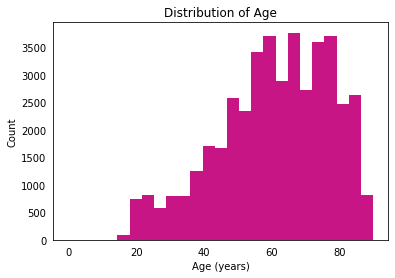

In [44]:
plt.hist(data['age'],range=[0,90],bins=25, color='mediumvioletred')
plt.ylabel('Count')
plt.xlabel('Age (years)')
plt.title('Distribution of Age')
plt.tick_params(left=False, bottom=False, top=False, right=False)
plt.show();

In [45]:
dum=data

In [46]:
#IMPORTING NOTEEVENTS
df_notes=pd.read_csv('~/Downloads/NOTEEVENTS.csv.gz')

/Users/harikapolaki/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [47]:
df_notes.head()
df_notes.TEXT.iloc[0]

'Admission Date:  [**2151-7-16**]       Discharge Date:  [**2151-8-4**]\n\n\nService:\nADDENDUM:\n\nRADIOLOGIC STUDIES:  Radiologic studies also included a chest\nCT, which confirmed cavitary lesions in the left lung apex\nconsistent with infectious process/tuberculosis.  This also\nmoderate-sized left pleural effusion.\n\nHEAD CT:  Head CT showed no intracranial hemorrhage or mass\neffect, but old infarction consistent with past medical\nhistory.\n\nABDOMINAL CT:  Abdominal CT showed lesions of\nT10 and sacrum most likely secondary to osteoporosis. These can\nbe followed by repeat imaging as an outpatient.\n\n\n\n                            [**First Name8 (NamePattern2) **] [**First Name4 (NamePattern1) 1775**] [**Last Name (NamePattern1) **], M.D.  [**MD Number(1) 1776**]\n\nDictated By:[**Hospital 1807**]\nMEDQUIST36\n\nD:  [**2151-8-5**]  12:11\nT:  [**2151-8-5**]  12:21\nJOB#:  [**Job Number 1808**]\n'

In [48]:
df_notes_dischsum = df_notes.loc[df_notes.CATEGORY == 'Discharge summary']
df_notes_dischsum_last = (df_notes_dischsum.groupby(['SUBJECT_ID','HADM_ID']).nth(-1)).reset_index()
assert df_notes_dischsum_last.duplicated(['HADM_ID']).sum() == 0, 'Multiple discharge summaries per admission'
df_admis_notes = pd.merge(dum,df_notes_dischsum_last[['SUBJECT_ID','HADM_ID','TEXT']],on = ['SUBJECT_ID','HADM_ID'],how = 'left')

In [49]:
print('Fraction of missing notes:', df_admis_notes.TEXT.isnull().sum() / len(df_admis_notes))
print('Fraction notes with newlines:', df_admis_notes.TEXT.str.contains('\n').sum() / len(df_admis_notes))
print('Fraction notes with carriage returns:', df_admis_notes.TEXT.str.contains('\r').sum() / len(df_admis_notes))

Fraction of missing notes: 0.030504037625343865
Fraction notes with newlines: 0.9694959623746562
Fraction notes with carriage returns: 0.0


In [50]:
df_admis_notes_clean = df_admis_notes.loc[df_admis_notes.ADMISSION_TYPE != 'NEWBORN'].copy()
df_admis_notes_clean['OUTPUT_LABEL']=df_admis_notes_clean['READMISSION'].astype(int)
df_admis_notes_clean.to_csv('HapFinalProjectCleaned.csv')

In [51]:
print('Number of positive samples:', (df_admis_notes_clean.OUTPUT_LABEL == 1).sum())
print('Number of negative samples:',  (df_admis_notes_clean.OUTPUT_LABEL == 0).sum())
print('Total samples:', len(df_admis_notes_clean))

Number of positive samples: 2958
Number of negative samples: 42118
Total samples: 45076


In [52]:
df = df_admis_notes_clean

In [53]:
import nltk
from nltk import word_tokenize
import string
import re
print(string.punctuation)

def preprocess_text(df):
    # This function preprocesses the text by filling not a number and replacing new lines ('\n') and carriage returns ('\r')
    df.TEXT = df.TEXT.fillna(' ')
    df.TEXT =df.TEXT.str.replace('\n',' ')
    df.TEXT =df.TEXT.str.replace('\r',' ')
    return df

df = preprocess_text(df)

stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()
wn = nltk.WordNetLemmatizer()

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [54]:
df.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,ADMISSION_TYPE,ETHNICITY,DIAGNOSIS,READMISSION,blood,circulatory,congenital,...,respiratory,skin,DOB,GENDER,ADMIT_MIN,date_DOB,date_ADMIT,age,TEXT,OUTPUT_LABEL
0,3,145834,2101-10-20 19:08:00,EMERGENCY,WHITE,HYPOTENSION,0,0,4,0,...,0,1,2025-04-11,M,2101-10-20,2025-04-11,2101-10-20,76,Admission Date: [**2101-10-20**] Discharg...,0
1,4,185777,2191-03-16 00:28:00,EMERGENCY,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,0,0,0,...,0,0,2143-05-12,F,2191-03-16,2143-05-12,2191-03-16,47,Admission Date: [**2191-3-16**] Discharge...,0
2,6,107064,2175-05-30 07:15:00,ELECTIVE,WHITE,CHRONIC RENAL FAILURE/SDA,0,1,2,0,...,0,0,2109-06-21,F,2175-05-30,2109-06-21,2175-05-30,65,Admission Date: [**2175-5-30**] Dischar...,0
3,11,194540,2178-04-16 06:18:00,EMERGENCY,WHITE,BRAIN MASS,0,0,0,0,...,0,0,2128-02-22,F,2178-04-16,2128-02-22,2178-04-16,50,Admission Date: [**2178-4-16**] ...,0
4,13,143045,2167-01-08 18:43:00,EMERGENCY,WHITE,CORONARY ARTERY DISEASE,0,0,3,0,...,0,0,2127-02-27,F,2167-01-08,2127-02-27,2167-01-08,39,"Name: [**Known lastname 9900**], [**Known fir...",0


In [55]:
def clean_textmain(text):
    text = text.lower()
    text ="".join([char for char in text if char not in string.punctuation ])
    result = re.sub(r'[0-9]+','',text)
    tokens = re.split('\W+', result)
    words = [word for word in tokens if word.isalpha()]
    text1=[word for word in words if word not in string.digits]
    text = [wn.lemmatize(word) for word in text1 if word not in stopwords]
    return text



In [56]:
from sklearn.feature_extraction.text import CountVectorizer


In [57]:
count_vect_sample = CountVectorizer(max_features = 3000,analyzer = clean_textmain)


In [58]:
import nltk

In [59]:
#nltk.download()

In [60]:
X_counts_sample = count_vect_sample.fit_transform(df['TEXT'])
print(X_counts_sample.shape)

(45076, 3000)


In [61]:
X_counts_df =pd.DataFrame(X_counts_sample.toarray())
X_counts_df.columns = count_vect_sample.get_feature_names()
X_counts_df.head()

,aaa,aaox,ab,abd,abdomen,abdominal,abdpelvis,abg,ability,ablation,...,yeastnone,yellow,yesterday,yo,yr,zantac,zocor,zofran,zolpidem,zosyn
0,0,0,0,0,1,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
data = df.join(X_counts_df,lsuffix='_caller', rsuffix='_other')
data.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,ADMISSION_TYPE,ETHNICITY,DIAGNOSIS,READMISSION,blood_caller,circulatory,congenital,...,yeastnone,yellow,yesterday,yo,yr,zantac,zocor,zofran,zolpidem,zosyn
0,3,145834,2101-10-20 19:08:00,EMERGENCY,WHITE,HYPOTENSION,0,0,4,0,...,0,0,0,0,0,0,0,0,0,0
1,4,185777,2191-03-16 00:28:00,EMERGENCY,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,6,107064,2175-05-30 07:15:00,ELECTIVE,WHITE,CHRONIC RENAL FAILURE/SDA,0,1,2,0,...,0,0,1,0,0,0,0,0,0,0
3,11,194540,2178-04-16 06:18:00,EMERGENCY,WHITE,BRAIN MASS,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,13,143045,2167-01-08 18:43:00,EMERGENCY,WHITE,CORONARY ARTERY DISEASE,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
data.drop(columns=['SUBJECT_ID', 'HADM_ID', 'ADMITTIME' ,'ADMISSION_TYPE','READMISSION','ADMIT_MIN', 'DOB','DIAGNOSIS'], inplace=True)
df= data
df.columns
df = pd.get_dummies(data=df, columns=['ETHNICITY', 'GENDER'])
df = df.dropna()

In [64]:
count_classes = pd.value_counts(df['OUTPUT_LABEL'], sort = True)
count_classes

0    42118
1     2958
Name: OUTPUT_LABEL, dtype: int64

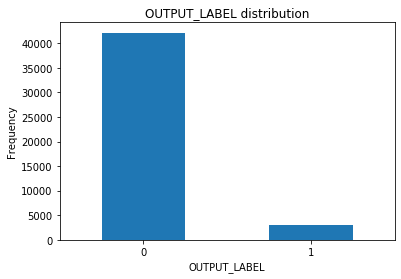

In [65]:
Labels = ["No readmission", "Readmission <30"]
plt.title("OUTPUT_LABEL distribution")
plt.xticks(range(2), Labels)
plt.xlabel("OUTPUT_LABEL")
plt.ylabel("Frequency")
count_classes.plot(kind = 'bar', rot=0)

In [66]:
print('Readmissions after 30 Days', round(data['OUTPUT_LABEL'].value_counts()[0]/len(df) * 100,3), '% of the dataset')
print('Readmssions with in 30 Days', round(data['OUTPUT_LABEL'].value_counts()[1]/len(df) * 100,3), '% of the dataset')

Readmissions after 30 Days 93.438 % of the dataset
Readmssions with in 30 Days 6.562 % of the dataset


In [67]:
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
import datetime 
%matplotlib inline
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection  import train_test_split 
from sklearn.model_selection  import KFold 
from sklearn.model_selection  import GridSearchCV  
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.metrics import confusion_matrix,recall_score,precision_recall_curve,auc,roc_curve,roc_auc_score,classification_report
import warnings
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2
#from imblearn.over_sampling import RandomOverSampler
from collections import Counter
warnings.filterwarnings('ignore')
data = df
data.head()

,blood_caller,circulatory,congenital,digestive,endocrine_caller,genitourinary,infectious_caller,injury_caller,mental_caller,misc,...,zofran,zolpidem,zosyn,ETHNICITY_ASIAN,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_HISPANIC/LATINO,ETHNICITY_OTHER/UNKNOWN,ETHNICITY_WHITE,GENDER_F,GENDER_M
0,0,4,0,0,1,1,1,0,0,1,...,0,0,0,0,0,0,0,1,0,1
1,0,0,0,1,1,0,3,2,0,2,...,0,0,0,0,0,0,0,1,1,0
2,1,2,0,0,3,0,0,2,0,0,...,0,0,0,0,0,0,0,1,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,0,3,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [68]:
#data.drop(columns=['Unnamed: 0','Unnamed: 0.1'], inplace=True)
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df = data.select_dtypes(include=numerics)
cols=list(df.columns)
cols.remove('OUTPUT_LABEL')
df.shape

(45076, 3002)

In [69]:
#UNDER SAMPLING
#SHUFFLING THE SAMPLES
df = df.sample(n = len(df), random_state = 42)
df = df.reset_index(drop = True)


In [70]:
# 30% AS TEST AND VALIDATION SET
df_test=df.sample(frac=0.20,random_state=42)

# REAMINING AS TRAINING SET
df_train_all=df.drop(df_test.index)

print('Test prevalence(n = %d):'%len(df_test),df_test.OUTPUT_LABEL.sum()/ len(df_test))
print('Train all prevalence(n = %d):'%len(df_train_all), df_train_all.OUTPUT_LABEL.sum()/ len(df_train_all))
print('all samples (n = %d)'%len(df))

Test prevalence(n = 9015): 0.06699944536882972
Train all prevalence(n = 36061): 0.06527827847258812
all samples (n = 45076)


In [71]:
# SPLITTING TARINING SET INTO POSITIVE AND NEGATIVE
rows_pos = df_train_all.OUTPUT_LABEL == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

# MERGING BALANCED DATA
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)],axis = 0)

In [72]:
# SHUFFLING THE ORDER OF TRAINING SET
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)
print('Train prevalence (n = %d):'%len(df_train), df_train.OUTPUT_LABEL.sum()/ len(df_train))

Train prevalence (n = 4708): 0.5


In [73]:
df_train.head()

,age_caller,OUTPUT_LABEL,aaa,aaox,ab,abd,abdomen,abdominal,abdpelvis,abg,...,yeastnone,yellow,yesterday,yo,yr,zantac,zocor,zofran,zolpidem,zosyn
0,50,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,73,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,55,0,0,0,0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,60,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,28,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [74]:
X_train_tf = df_train[cols].values
X_test_tf = df_test[cols].values
y_train = df_train.OUTPUT_LABEL
y_test = df_test.OUTPUT_LABEL

In [75]:
  from sklearn.ensemble import RandomForestClassifier

In [76]:
clf=RandomForestClassifier(n_estimators=300)
clf.fit(X_train_tf, y_train)

model = clf
y_train_preds = model.predict_proba(X_train_tf)[:,1]
y_test_preds = model.predict_proba(X_test_tf)[:,1]
print(y_train[:10].values)
print(y_train_preds[:10])

[1 1 0 0 1 1 0 0 0 1]
[0.78333333 0.77666667 0.20333333 0.12       0.91333333 0.83333333
 0.09666667 0.20333333 0.16       0.83      ]


In [77]:
def calc_accuracy(y_actual, y_pred, thresh):
    # this function calculates the accuracy with probability threshold at thresh
    return (sum((y_pred > thresh) & (y_actual == 1))+sum((y_pred < thresh) & (y_actual == 0))) /len(y_actual)

def calc_recall(y_actual, y_pred, thresh):
    # calculates the recall
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_actual)

def calc_precision(y_actual, y_pred, thresh):
    # calculates the precision
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_pred > thresh)

def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def calc_prevalence(y_actual):
    # calculates prevalence
    return sum((y_actual == 1)) /len(y_actual)

In [78]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
fpr_test, tpr_test, thresholds_tets = roc_curve(y_test, y_test_preds)


thresh = 0.5

auc_train = roc_auc_score(y_train, y_train_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

print('Train AUC:%.3f'%auc_train)
print('Test AUC:%.3f'%auc_test)

print('Train accuracy:%.3f'%calc_accuracy(y_train, y_train_preds, thresh))
print('Test accuracy:%.3f'%calc_accuracy(y_test, y_test_preds, thresh))


print('Train recall:%.3f'%calc_recall(y_train, y_train_preds, thresh))
print('Test recall:%.3f'%calc_recall(y_test,y_test_preds, thresh))

print('Train precision:%.3f'%calc_precision(y_train, y_train_preds, thresh))
print('Test precision:%.3f'%calc_precision(y_test, y_test_preds, thresh))

print('Train specificity:%.3f'%calc_specificity(y_train, y_train_preds, thresh))
print('Test specificity:%.3f'%calc_specificity(y_test, y_test_preds, thresh))

print('Train prevalence:%.3f'%calc_prevalence(y_train))
print('Test prevalence:%.3f'%calc_prevalence(y_test))

Train AUC:1.000
Test AUC:0.676
Train accuracy:0.994
Test accuracy:0.592
Train recall:0.992
Test recall:0.667
Train precision:0.996
Test precision:0.105
Train specificity:0.996
Test specificity:0.586
Train prevalence:0.500
Test prevalence:0.067


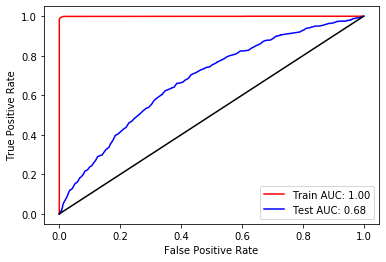

In [79]:
plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_test, tpr_test,'b-',label = 'Test AUC: %.2f'%auc_test)
plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

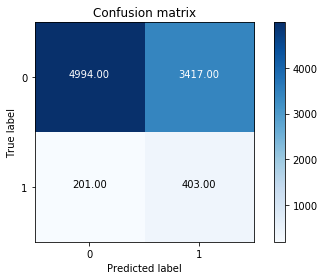

In [80]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


cnf_matrix=confusion_matrix(y_test,y_test_preds.round())
plot_confusion_matrix(cnf_matrix,classes=[0,1])
plt.show()

In [81]:
rf = RandomForestClassifier()
rf.fit(X_train_tf, y_train)
probs_rf = rf.predict_proba(X_test_tf)
res = pd.DataFrame()
res['Output_label'] = y_test
res['rf'] = probs_rf[:,1]
res.head(10)

,Output_label,rf
25182,0,0.12
39747,0,0.56
12048,0,0.63
29929,0,0.51
27310,0,0.39
22254,0,0.23
4518,0,0.39
11196,0,0.56
853,0,0.23
38109,0,0.38


In [82]:
fpr_rf, tpr_rf, threshold_rf = roc_curve(res['Output_label'] , res['rf'])
auc_rf = auc(fpr_rf ,tpr_rf)
print(auc_rf)

0.6701190927049963


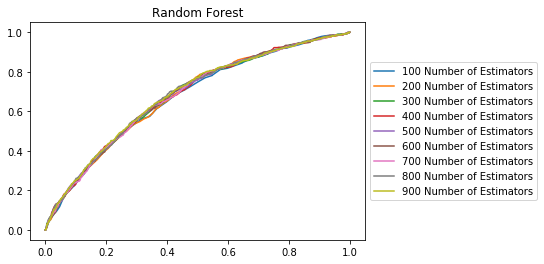

In [83]:
rf = dict()
probs_rf = dict()
fpr_rf = dict()
tpr_rf = dict()
thresholds_rf = dict()
auc_rf = dict()
Auc =[]
Number_of_Estimators =[]
for n in range(100, 1000, 100):
    rf[n]=RandomForestClassifier(n_estimators =n)
    rf[n].fit(X_train_tf, y_train)
    probs_rf[n]=rf[n].predict_proba(X_test_tf)
    fpr_rf[n], tpr_rf[n], thresholds_rf[n] = roc_curve(y_test,probs_rf[n][:,1])
    auc_rf[n]=auc(fpr_rf[n],tpr_rf[n])
    Auc.append(auc_rf[n])
    Number_of_Estimators.append(n)
    plt.title('Random Forest')
    plt.plot(fpr_rf[n], tpr_rf[n],label = "{} Number of Estimators".format(n))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

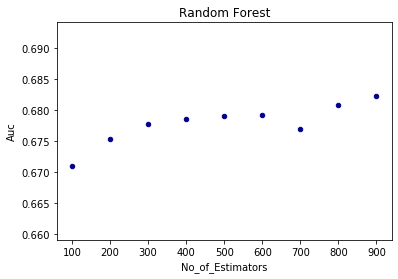

In [84]:
aucperform= pd.DataFrame({'No_of_Estimators':Number_of_Estimators,'Auc':Auc})
aucperform.plot.scatter(x='No_of_Estimators',y='Auc',c='DarkBlue',title = 'Random Forest')

In [85]:
#FEATURE SELECTION
mic = mutual_info_classif(X_train_tf, y_train)
mic
s = pd.DataFrame()
s['att'] = cols
s['mic'] = mic
chi2 = chi2(X_train_tf, y_train)
s['chi2'] = chi2[0]

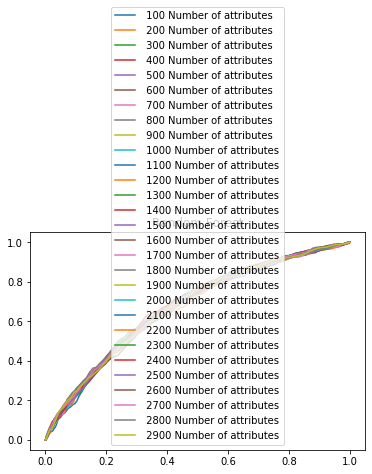

In [86]:
rf200=RandomForestClassifier(n_estimators=200)
Auc =[]
No_of_Attributes =[]
for n in range(100, 3000, 100):
    cols_sel_mic=s.sort_values('mic', ascending=False)['att'][:n]
    rf200.fit(df_train[cols_sel_mic],df_train['OUTPUT_LABEL'])
    probs_rf200=rf200.predict_proba(df_test[cols_sel_mic])
    fpr_rf200, tpr_rf200, thresholds_rf200 = roc_curve(df_test['OUTPUT_LABEL'],probs_rf200[:,1])
    auc_rf200=auc(fpr_rf200,tpr_rf200)
    Auc.append(auc_rf200)
    No_of_Attributes.append(n)
    plt.title('Random Forest')
    plt.plot(fpr_rf200, tpr_rf200,label =" {} Number of attributes".format(n))
    plt.legend(loc='Left')

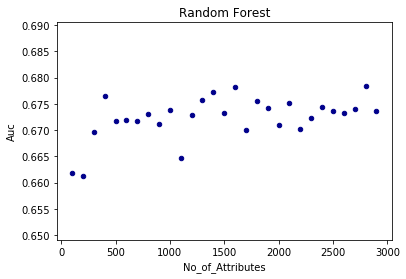

In [87]:
aucperform= pd.DataFrame({'No_of_Attributes':No_of_Attributes,'Auc':Auc})
aucperform.plot.scatter(x='No_of_Attributes',y='Auc',c='DarkBlue',title = 'Random Forest')

In [88]:
#OVER SAMPLING
df_test.shape
df_train_all.shape

X_train = df_train_all[cols].values
y_train = df_train_all.OUTPUT_LABEL

In [89]:
from imblearn.over_sampling import RandomOverSampler

In [90]:
os =  RandomOverSampler(sampling_strategy=1)


In [91]:
X_train_res, y_train_res = os.fit_sample(X_train, y_train)

print ("Distribution of class labels before resampling {}".format(Counter(y_train)))
print ("Distribution of class labels after resampling {}".format(Counter(y_train_res)))

Distribution of class labels before resampling Counter({0: 33707, 1: 2354})
Distribution of class labels after resampling Counter({0: 33707, 1: 33707})


In [92]:
X_test_tf.shape
y_test.shape

(9015,)

In [93]:
clf=RandomForestClassifier(n_estimators=300)
clf.fit(X_train_res, y_train_res)

model = clf
y_train_preds = model.predict_proba(X_train_res)[:,1]
y_test_preds = model.predict_proba(X_test_tf)[:,1]

In [94]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_res, y_train_preds)
fpr_test, tpr_test, thresholds_tets = roc_curve(y_test, y_test_preds)


In [95]:
thresh = 0.5

In [96]:
auc_train = roc_auc_score(y_train_res, y_train_preds)
auc_test = roc_auc_score(y_test, y_test_preds)


In [97]:
print('Train AUC:%.3f'%auc_train)
print('Test AUC:%.3f'%auc_test)

print('Train accuracy:%.3f'%calc_accuracy(y_train_res, y_train_preds, thresh))
print('Test accuracy:%.3f'%calc_accuracy(y_test, y_test_preds, thresh))


print('Train recall:%.3f'%calc_recall(y_train_res, y_train_preds, thresh))
print('Test recall:%.3f'%calc_recall(y_test,y_test_preds, thresh))

print('Train precision:%.3f'%calc_precision(y_train_res, y_train_preds, thresh))
print('Test precision:%.3f'%calc_precision(y_test, y_test_preds, thresh))

print('Train specificity:%.3f'%calc_specificity(y_train_res, y_train_preds, thresh))
print('Test specificity:%.3f'%calc_specificity(y_test, y_test_preds, thresh))

print('Train prevalence:%.3f'%calc_prevalence(y_train_res))
print('Test prevalence:%.3f'%calc_prevalence(y_test))

Train AUC:1.000
Test AUC:0.674
Train accuracy:0.993
Test accuracy:0.926
Train recall:0.994
Test recall:0.015
Train precision:0.992
Test precision:0.108
Train specificity:0.992
Test specificity:0.991
Train prevalence:0.500
Test prevalence:0.067


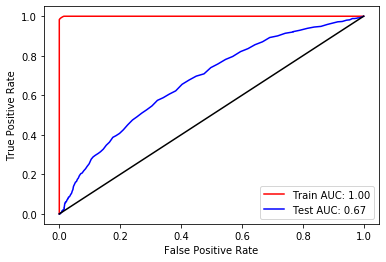

In [98]:
plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_test, tpr_test,'b-',label = 'Test AUC: %.2f'%auc_test)
plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

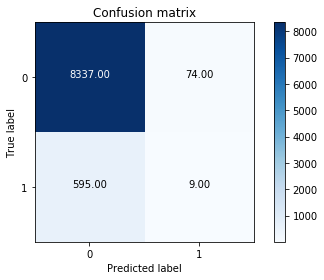

In [99]:
cnf_matrix=confusion_matrix(y_test,y_test_preds.round())
plot_confusion_matrix(cnf_matrix,classes=[0,1])
plt.show()

In [100]:
#OVER SAMPLING AND UNDERSAMPLING
X_test1=df_test[cols]
X_train1=df_train_all[cols]
y_test1=df_test.OUTPUT_LABEL
y_train1=df_train_all.OUTPUT_LABEL

In [101]:
print(X_test1.shape)
print(y_test1.shape)
print(X_train1.shape)
print(y_train1.shape)

(9015, 3001)
(9015,)
(36061, 3001)
(36061,)


In [102]:
from sklearn.metrics import recall_score,accuracy_score,confusion_matrix, f1_score, precision_score, auc,roc_auc_score,roc_curve, precision_recall_curve
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import ClusterCentroids,NearMiss, RandomUnderSampler
from imblearn.combine import SMOTEENN,SMOTETomek
#from imblearn.ensemble import BalanceCascade
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection  import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [118]:
def benchmark(sampling_type,X,y):
    lr = LogisticRegression(penalty = 'l2')
    param_grid = {'C':[0.01,0.1,1,10]}
    gs = GridSearchCV(estimator=lr, param_grid=param_grid, scoring='accuracy', cv=5, verbose=2)
    gs = gs.fit(X,y)
    return sampling_type,gs.best_score_,gs.best_params_['C']

In [119]:
def transform(transformer,X,y):
    print("Transforming {}".format(transformer.__class__.__name__))
    X_resampled,y_resampled = transformer.fit_sample(X,y)
    return transformer.__class__.__name__,pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)

In [120]:
datasets = []
datasets.append(("base",X_train1,y_train1))
datasets.append(transform(SMOTE(n_jobs=-1),X_train1,y_train1))
datasets.append(transform(RandomOverSampler(),X_train1,y_train1))
datasets.append(transform(NearMiss(n_jobs=-1),X_train1,y_train1))
datasets.append(transform(RandomUnderSampler(),X_train1,y_train1))

Transforming SMOTE
Transforming RandomOverSampler
Transforming NearMiss
Transforming RandomUnderSampler


In [121]:
benchmark_scores = []
for sample_type,X,y in datasets:
    print('______________________________________________________________')
    print('{}'.format(sample_type))
    benchmark_scores.append(benchmark(sample_type,X,y))
    print('______________________________________________________________')

______________________________________________________________
base
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................................... C=0.01, total=  10.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.3s remaining:    0.0s


[CV] ........................................... C=0.01, total=  10.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=  10.2s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   9.9s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   9.9s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   9.9s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=  10.2s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=  10.1s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  3.3min finished


______________________________________________________________
______________________________________________________________
SMOTE
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................................... C=0.01, total=  26.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.8s remaining:    0.0s


[CV] ........................................... C=0.01, total=  19.5s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=  20.2s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=  20.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=  19.7s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=  20.2s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=  19.5s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=  20.0s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  6.8min finished


______________________________________________________________
______________________________________________________________
RandomOverSampler
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................................... C=0.01, total=  26.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.1s remaining:    0.0s


[CV] ........................................... C=0.01, total=  20.9s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=  20.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=  19.4s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=  19.7s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=  19.9s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=  20.4s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=  19.5s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  6.8min finished


______________________________________________________________
______________________________________________________________
NearMiss
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................................... C=0.01, total=   1.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] ........................................... C=0.01, total=   0.7s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.7s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.8s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   15.3s finished


______________________________________________________________
______________________________________________________________
RandomUnderSampler
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................................... C=0.01, total=   0.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] ........................................... C=0.01, total=   0.7s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.7s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.7s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   14.2s finished


______________________________________________________________


In [129]:
from sklearn.metrics import roc_auc_score

In [131]:
scores = []
# train models based on benchmark params
for sampling_type,score,param in benchmark_scores:
    print("Training on {}".format(sampling_type))
    lr = LogisticRegression(penalty = 'l2',C=param)
    for s_type,X,y in datasets:
        if s_type == sampling_type:
            lr.fit(X,y)
            pred_test = lr.predict(X_test_tf)
            pred_test_probs = lr.predict_proba(X_test_tf)
            probs = lr.decision_function(X_test_tf)
            fpr, tpr, thresholds = roc_curve(y_test.values.ravel(),pred_test)
            p,r,t = precision_recall_curve(y_test.values.ravel(),probs)
            scores.append((sampling_type,
                           f1_score(y_test.values.ravel(),pred_test),
                           precision_score(y_test.values.ravel(),pred_test),
                           recall_score(y_test.values.ravel(),pred_test),
                           accuracy_score(y_test.values.ravel(),pred_test),
                           auc(fpr, tpr),
                           
                           
                           confusion_matrix(y_test.values.ravel(),pred_test)))

Training on base
Training on SMOTE
Training on RandomOverSampler
Training on NearMiss
Training on RandomUnderSampler


In [133]:
sampling_results = pd.DataFrame(scores,columns=['Sampling Type','f1','precision','recall','accuracy','auc_roc','confusion_matrix'])
sampling_results

,Sampling Type,f1,precision,recall,accuracy,auc_roc,confusion_matrix
0,base,0.165944,0.102056,0.443709,0.701165,0.581681,"[[6053, 2358], [336, 268]]"
1,SMOTE,0.099806,0.056533,0.425497,0.485746,0.457785,"[[4122, 4289], [347, 257]]"
2,RandomOverSampler,0.155743,0.088307,0.658940,0.521353,0.585207,"[[4302, 4109], [206, 398]]"
3,NearMiss,0.155457,0.102714,0.319536,0.767388,0.559542,"[[6725, 1686], [411, 193]]"
4,RandomUnderSampler,0.160502,0.092818,0.592715,0.584581,0.588356,"[[4912, 3499], [246, 358]]"


In [157]:
# shuffle the samples
df_data = df.sample(n = len(df), random_state = 42)


In [158]:
df_data = df.reset_index(drop = True)

In [159]:

df_valid_test=df_data.sample(frac=0.30,random_state=42)
print('Split size: %.3f'%(len(df_valid_test)/len(df_data)))

Split size: 0.300


In [160]:
df_test = df_valid_test.sample(frac = 0.5, random_state = 42)
df_valid = df_valid_test.drop(df_test.index)

In [161]:
# use the rest of the data as training data
df_train_all=df_data.drop(df_valid_test.index)

In [162]:
print('Test prevalence(n = %d):%.3f'%(len(df_test),calc_prevalence(df_test.OUTPUT_LABEL.values)))
print('Valid prevalence(n = %d):%.3f'%(len(df_valid),calc_prevalence(df_valid.OUTPUT_LABEL.values)))
print('Train all prevalence(n = %d):%.3f'%(len(df_train_all), calc_prevalence(df_train_all.OUTPUT_LABEL.values)))


Test prevalence(n = 6762):0.065
Valid prevalence(n = 6761):0.070
Train all prevalence(n = 31553):0.065


In [163]:
print('all samples (n = %d)'%len(df_data))
assert len(df_data) == (len(df_test)+len(df_valid)+len(df_train_all)),'math didnt work'

all samples (n = 45076)


In [164]:
# split the training data into positive and negative
rows_pos = df_train_all.OUTPUT_LABEL == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

# merge the balanced data
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)],axis = 0)

# shuffle the order of training samples 
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)

print('Train balanced prevalence(n = %d):%.3f'%(len(df_train), calc_prevalence(df_train.OUTPUT_LABEL.values)))

Train balanced prevalence(n = 4090):0.500


In [165]:
df_train_all.to_csv('df_train_all.csv',index=False)
df_train.to_csv('df_train.csv',index=False)
df_valid.to_csv('df_valid.csv',index=False)
df_test.to_csv('df_test.csv',index=False)

In [167]:
X_train = df_train[cols].values
X_train_all = df_train_all[cols].values
X_valid = df_valid[cols].values


In [168]:
y_train = df_train['OUTPUT_LABEL'].values
y_valid = df_valid['OUTPUT_LABEL'].values

print('Training All shapes:',X_train_all.shape)
print('Training shapes:',X_train.shape, y_train.shape)
print('Validation shapes:',X_valid.shape, y_valid.shape)

Training All shapes: (31553, 3001)
Training shapes: (4090, 3001) (4090,)
Validation shapes: (6761, 3001) (6761,)


In [170]:
from sklearn.preprocessing import StandardScaler

scaler  = StandardScaler()
scaler.fit(X_train_all)

StandardScaler()

In [171]:
import pickle
scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

In [172]:
scaler = pickle.load(open(scalerfile, 'rb'))

In [173]:
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)

In [174]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity

In [175]:
thresh = 0.5

In [176]:
# k-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors = 100)
knn.fit(X_train_tf, y_train)

KNeighborsClassifier(n_neighbors=100)

In [177]:
y_train_preds = knn.predict_proba(X_train_tf)[:,1]
y_valid_preds = knn.predict_proba(X_valid_tf)[:,1]

print('KNN')
print('Training:')
knn_train_auc, knn_train_accuracy, knn_train_recall, \
    knn_train_precision, knn_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
knn_valid_auc, knn_valid_accuracy, knn_valid_recall, \
    knn_valid_precision, knn_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

KNN
Training:
AUC:0.646
accuracy:0.586
recall:0.301
precision:0.699
specificity:0.821
prevalence:0.500
 
Validation:
AUC:0.572
accuracy:0.814
recall:0.242
precision:0.114
specificity:0.813
prevalence:0.070
 


In [179]:
# logistic regression
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(random_state = 42)
lr.fit(X_train_tf, y_train)

LogisticRegression(random_state=42)

In [180]:
y_train_preds = lr.predict_proba(X_train_tf)[:,1]
y_valid_preds = lr.predict_proba(X_valid_tf)[:,1]

print('Logistic Regression')
print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Logistic Regression
Training:
AUC:1.000
accuracy:0.989
recall:0.979
precision:0.999
specificity:0.999
prevalence:0.500
 
Validation:
AUC:0.570
accuracy:0.591
recall:0.517
precision:0.088
specificity:0.597
prevalence:0.070
 


In [181]:
from sklearn.linear_model import SGDClassifier
sgdc=SGDClassifier(loss = 'log',alpha = 0.1,random_state = 42)
sgdc.fit(X_train_tf, y_train)


SGDClassifier(alpha=0.1, loss='log', random_state=42)

In [182]:
y_train_preds = sgdc.predict_proba(X_train_tf)[:,1]
y_valid_preds = sgdc.predict_proba(X_valid_tf)[:,1]

print('Stochastic Gradient Descend')
print('Training:')
sgdc_train_auc, sgdc_train_accuracy, sgdc_train_recall, sgdc_train_precision, sgdc_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
sgdc_valid_auc, sgdc_valid_accuracy, sgdc_valid_recall, sgdc_valid_precision, sgdc_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Stochastic Gradient Descend
Training:
AUC:0.960
accuracy:0.884
recall:0.852
precision:0.910
specificity:0.915
prevalence:0.500
 
Validation:
AUC:0.619
accuracy:0.640
recall:0.527
precision:0.102
specificity:0.648
prevalence:0.070
 


In [183]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train_tf, y_train)

GaussianNB()

In [184]:
y_train_preds = nb.predict_proba(X_train_tf)[:,1]
y_valid_preds = nb.predict_proba(X_valid_tf)[:,1]

print('Naive Bayes')
print('Training:')
nb_train_auc, nb_train_accuracy, nb_train_recall, nb_train_precision, nb_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
nb_valid_auc, nb_valid_accuracy, nb_valid_recall, nb_valid_precision, nb_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Naive Bayes
Training:
AUC:0.709
accuracy:0.661
recall:0.573
precision:0.695
specificity:0.749
prevalence:0.500
 
Validation:
AUC:0.645
accuracy:0.694
recall:0.534
precision:0.121
specificity:0.706
prevalence:0.070
 


In [185]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth = 10, random_state = 42)
tree.fit(X_train_tf, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [186]:
y_train_preds = tree.predict_proba(X_train_tf)[:,1]
y_valid_preds = tree.predict_proba(X_valid_tf)[:,1]

print('Decision Tree')
print('Training:')
tree_train_auc, tree_train_accuracy, tree_train_recall, tree_train_precision, tree_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
tree_valid_auc, tree_valid_accuracy, tree_valid_recall, tree_valid_precision, tree_valid_specificity = print_report(y_valid,y_valid_preds, thresh)


Decision Tree
Training:
AUC:0.873
accuracy:0.787
recall:0.754
precision:0.806
specificity:0.819
prevalence:0.500
 
Validation:
AUC:0.580
accuracy:0.620
recall:0.532
precision:0.097
specificity:0.626
prevalence:0.070
 


In [187]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(max_depth = 6, random_state = 42)
rf.fit(X_train_tf, y_train)

RandomForestClassifier(max_depth=6, random_state=42)

In [188]:
y_train_preds = rf.predict_proba(X_train_tf)[:,1]
y_valid_preds = rf.predict_proba(X_valid_tf)[:,1]

print('Random Forest')
print('Training:')
rf_train_auc, rf_train_accuracy, rf_train_recall, rf_train_precision, rf_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
rf_valid_auc, rf_valid_accuracy, rf_valid_recall, rf_valid_precision, rf_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Random Forest
Training:
AUC:0.816
accuracy:0.739
recall:0.672
precision:0.776
specificity:0.806
prevalence:0.500
 
Validation:
AUC:0.647
accuracy:0.671
recall:0.565
precision:0.118
specificity:0.680
prevalence:0.070
 


In [189]:
from sklearn.ensemble import GradientBoostingClassifier
gbc =GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=3, random_state=42)
gbc.fit(X_train_tf, y_train)

GradientBoostingClassifier(learning_rate=1.0, random_state=42)

In [190]:
y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

print('Gradient Boosting Classifier')
print('Training:')
gbc_train_auc, gbc_train_accuracy, gbc_train_recall, gbc_train_precision, gbc_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
gbc_valid_auc, gbc_valid_accuracy, gbc_valid_recall, gbc_valid_precision, gbc_valid_specificity = print_report(y_valid,y_valid_preds, thresh)


Gradient Boosting Classifier
Training:
AUC:0.988
accuracy:0.945
recall:0.932
precision:0.956
specificity:0.957
prevalence:0.500
 
Validation:
AUC:0.605
accuracy:0.618
recall:0.546
precision:0.099
specificity:0.623
prevalence:0.070
 


In [191]:
df_results = pd.DataFrame({'classifier':['KNN','KNN','LR','LR','SGD','SGD','NB','NB','DT','DT','RF','RF','GB','GB'],
                           'data_set':['train','valid']*7,
                          'auc':[knn_train_auc, knn_valid_auc,lr_train_auc,lr_valid_auc,sgdc_train_auc,sgdc_valid_auc,nb_train_auc,nb_valid_auc,tree_train_auc,tree_valid_auc,rf_train_auc,rf_valid_auc,gbc_valid_auc,gbc_valid_auc,],
                          'accuracy':[knn_train_accuracy, knn_valid_accuracy,lr_train_accuracy,lr_valid_accuracy,sgdc_train_accuracy,sgdc_valid_accuracy,nb_train_accuracy,nb_valid_accuracy,tree_train_accuracy,tree_valid_accuracy,rf_train_accuracy,rf_valid_accuracy,gbc_valid_accuracy,gbc_valid_accuracy,],
                          'recall':[knn_train_recall, knn_valid_recall,lr_train_recall,lr_valid_recall,sgdc_train_recall,sgdc_valid_recall,nb_train_recall,nb_valid_recall,tree_train_recall,tree_valid_recall,rf_train_recall,rf_valid_recall,gbc_valid_recall,gbc_valid_recall,],
                          'precision':[knn_train_precision, knn_valid_precision,lr_train_precision,lr_valid_precision,sgdc_train_precision,sgdc_valid_precision,nb_train_precision,nb_valid_precision,tree_train_precision,tree_valid_precision,rf_train_precision,rf_valid_precision,gbc_valid_auc,gbc_valid_precision,],
                          'specificity':[knn_train_specificity, knn_valid_specificity,lr_train_specificity,lr_valid_specificity,sgdc_train_specificity,sgdc_valid_specificity,nb_train_specificity,nb_valid_specificity,tree_train_specificity,tree_valid_specificity,rf_train_specificity,rf_valid_specificity,gbc_valid_specificity,gbc_valid_specificity,]})


In [192]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

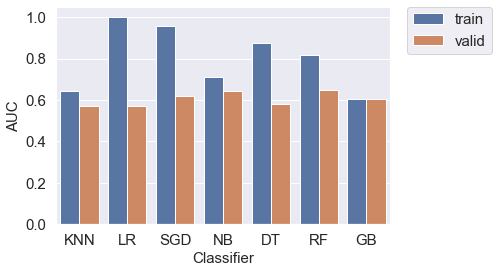

In [193]:
ax = sns.barplot(x="classifier", y="auc", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize=15)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)
plt.show()

In [195]:
#Feature Importance- Random Forest
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = cols,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)

In [196]:
feature_importances.head()

,importance
tid,0.014106
failure,0.011140
sig,0.010490
every,0.010387
po,0.008599


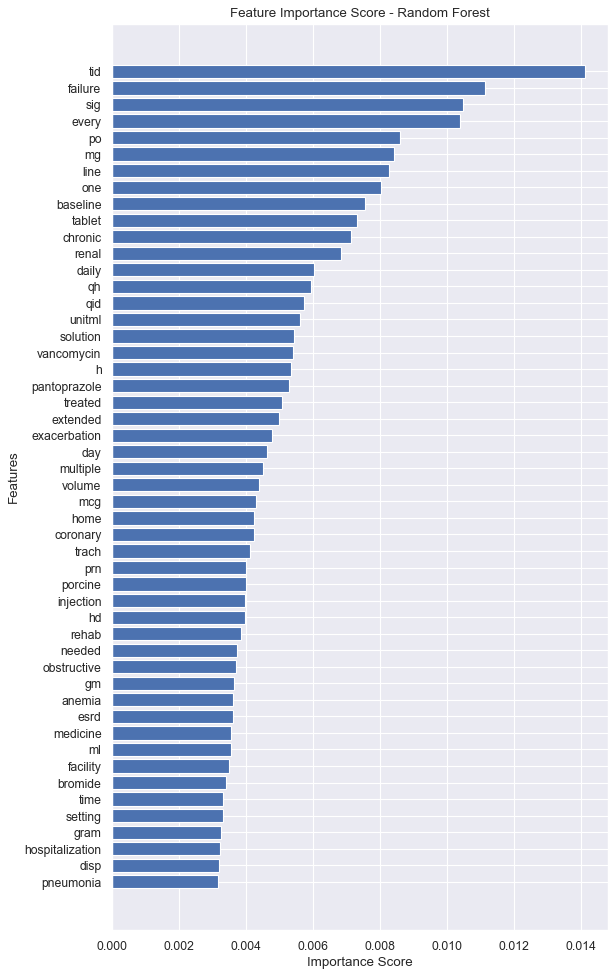

In [197]:
num = 50
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importance Score - Random Forest')
plt.yticks(ylocs, feature_labels)
plt.show()

In [198]:
#HYPERPARAMETER TUNING
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [199]:
from sklearn.model_selection import RandomizedSearchCV

# number of trees
n_estimators = range(200,1000,200)
# maximum number of features to use at each split
max_features = ['auto','sqrt']
# maximum depth of the tree
max_depth = range(1,10,1)
# minimum number of samples to split a node
min_samples_split = range(2,10,2)
# criterion for evaluating a split
criterion = ['gini','entropy']

# random grid

random_grid = {'n_estimators':n_estimators,
              'max_features':max_features,
              'max_depth':max_depth,
              'min_samples_split':min_samples_split,
              'criterion':criterion}

print(random_grid)

{'n_estimators': range(200, 1000, 200), 'max_features': ['auto', 'sqrt'], 'max_depth': range(1, 10), 'min_samples_split': range(2, 10, 2), 'criterion': ['gini', 'entropy']}


In [200]:
from sklearn.metrics import make_scorer, roc_auc_score
auc_scoring = make_scorer(roc_auc_score)

In [201]:
# create the randomized search cross-validation
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 20, cv = 2, scoring=auc_scoring,
                               verbose = 1, random_state = 42)

In [202]:
t1 = time.time()
rf_random.fit(X_train_tf, y_train)
t2 = time.time()
print(t2-t1)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  2.4min finished


154.37944102287292


In [203]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'max_features': 'auto',
 'max_depth': 9,
 'criterion': 'gini'}

In [204]:
y_train_preds = rf.predict_proba(X_train_tf)[:,1]
y_valid_preds = rf.predict_proba(X_valid_tf)[:,1]

print('Baseline Random Forest')
rf_train_auc_base = roc_auc_score(y_train, y_train_preds)
rf_valid_auc_base = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:%.3f'%(rf_train_auc_base))
print('Validation AUC:%.3f'%(rf_valid_auc_base))

print('Optimized Random Forest')
y_train_preds_random = rf_random.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_random = rf_random.best_estimator_.predict_proba(X_valid_tf)[:,1]

rf_train_auc = roc_auc_score(y_train, y_train_preds_random)
rf_valid_auc = roc_auc_score(y_valid, y_valid_preds_random)

print('Training AUC:%.3f'%(rf_train_auc))
print('Validation AUC:%.3f'%(rf_valid_auc))

Baseline Random Forest
Training AUC:0.816
Validation AUC:0.647
Optimized Random Forest
Training AUC:0.938
Validation AUC:0.662


In [205]:
penalty = ['none','l2','l1']
max_iter = range(100,500,100)
alpha = [0.001,0.003,0.01,0.03,0.1,0.3]
random_grid_sgdc = {'penalty':penalty,
              'max_iter':max_iter,
              'alpha':alpha}
# create the randomized search cross-validation
sgdc_random = RandomizedSearchCV(estimator = sgdc, param_distributions = random_grid_sgdc, 
                                 n_iter = 20, cv = 2, scoring=auc_scoring,verbose = 0, 
                                 random_state = 42)

t1 = time.time()
sgdc_random.fit(X_train_tf, y_train)
t2 = time.time()
print(t2-t1)

143.67541193962097


In [206]:
sgdc_random.best_params_

{'penalty': 'l2', 'max_iter': 100, 'alpha': 0.1}

In [207]:
y_train_preds = sgdc.predict_proba(X_train_tf)[:,1]
y_valid_preds = sgdc.predict_proba(X_valid_tf)[:,1]

print('Baseline sgdc')
sgdc_train_auc_base = roc_auc_score(y_train, y_train_preds)
sgdc_valid_auc_base = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:%.3f'%(sgdc_train_auc_base))
print('Validation AUC:%.3f'%(sgdc_valid_auc_base))
print('Optimized sgdc')
y_train_preds_random = sgdc_random.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_random = sgdc_random.best_estimator_.predict_proba(X_valid_tf)[:,1]
sgdc_train_auc = roc_auc_score(y_train, y_train_preds_random)
sgdc_valid_auc = roc_auc_score(y_valid, y_valid_preds_random)

print('Training AUC:%.3f'%(sgdc_train_auc))
print('Validation AUC:%.3f'%(sgdc_valid_auc))

Baseline sgdc
Training AUC:0.960
Validation AUC:0.619
Optimized sgdc
Training AUC:0.960
Validation AUC:0.619


In [210]:
 #number of trees
n_estimators = range(100,500,100)

# maximum depth of the tree
max_depth = range(1,5,1)

# learning rate
learning_rate = [0.001,0.01,0.1]

# random grid

random_grid_gbc = {'n_estimators':n_estimators,
              'max_depth':max_depth,
              'learning_rate':learning_rate}

# create the randomized search cross-validation
gbc_random = RandomizedSearchCV(estimator = gbc, param_distributions = random_grid_gbc,
                                n_iter = 20, cv = 2, scoring=auc_scoring,
                                verbose = 0, random_state = 42)



In [212]:

t1 = time.time()
gbc_random.fit(X_train_tf, y_train)
t2 = time.time()
print(t2-t1)

1927.832561969757


In [213]:
gbc_random.best_params_

{'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.1}

In [214]:
y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

print('Baseline gbc')
gbc_train_auc_base = roc_auc_score(y_train, y_train_preds)
gbc_valid_auc_base = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:%.3f'%(gbc_train_auc_base))
print('Validation AUC:%.3f'%(gbc_valid_auc_base))

print('Optimized gbc')
y_train_preds_random = gbc_random.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_random = gbc_random.best_estimator_.predict_proba(X_valid_tf)[:,1]
gbc_train_auc = roc_auc_score(y_train, y_train_preds_random)
gbc_valid_auc = roc_auc_score(y_valid, y_valid_preds_random)

print('Training AUC:%.3f'%(gbc_train_auc))
print('Validation AUC:%.3f'%(gbc_valid_auc))

Baseline gbc
Training AUC:0.988
Validation AUC:0.605
Optimized gbc
Training AUC:0.984
Validation AUC:0.670


In [230]:
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

In [235]:
nb_random = GridSearchCV(estimator=nb, 
                     param_grid=params_NB, 
                     cv=2,
                     verbose=1, 
                     scoring='accuracy')



In [237]:
from sklearn.preprocessing import PowerTransformer

In [241]:
Data_transformed = PowerTransformer().fit_transform(X_train_tf)

nb.fit(Data_transformed,  y_train);

In [249]:
nb_random.fit(X_train_tf, y_train)

Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   47.5s finished


GridSearchCV(cv=2, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.31...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='accuracy', verbose=1)

In [250]:
nb_random.best_params_

{'var_smoothing': 0.0015199110829529332}

In [252]:
y_train_preds = nb.predict_proba(X_train_tf)[:,1]
y_valid_preds = nb.predict_proba(X_valid_tf)[:,1]

print('Baseline nb')
nb_train_auc_base = roc_auc_score(y_train, y_train_preds)
nb_valid_auc_base = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:%.3f'%(nb_train_auc_base))
print('Validation AUC:%.3f'%(nb_valid_auc_base))

print('Optimized gbc')
y_train_preds_random = nb_random.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_random = nb_random.best_estimator_.predict_proba(X_valid_tf)[:,1]
nb_train_auc = roc_auc_score(y_train, y_train_preds_random)
nb_valid_auc = roc_auc_score(y_valid, y_valid_preds_random)

print('Training AUC:%.3f'%(nb_train_auc))
print('Validation AUC:%.3f'%(nb_valid_auc))

Baseline nb
Training AUC:0.653
Validation AUC:0.623
Optimized gbc
Training AUC:0.709
Validation AUC:0.645


In [254]:
#HYPERTUNING 
df_results = pd.DataFrame({'classifier':['SGD','SGD','RF','RF','GB','GB','NB','NB'],
                           'data_set':['base','optimized']*4,
                          'auc':[sgdc_valid_auc_base,sgdc_valid_auc,
                                 rf_valid_auc_base,rf_valid_auc,
                                 gbc_valid_auc_base,gbc_valid_auc,nb_valid_auc_base,nb_valid_auc,],
                          })

In [255]:
df_results

,classifier,data_set,auc
0,SGD,base,0.619462
1,SGD,optimized,0.619462
2,RF,base,0.646907
3,RF,optimized,0.662194
4,GB,base,0.605374
5,GB,optimized,0.670002
6,NB,base,0.623348
7,NB,optimized,0.645009


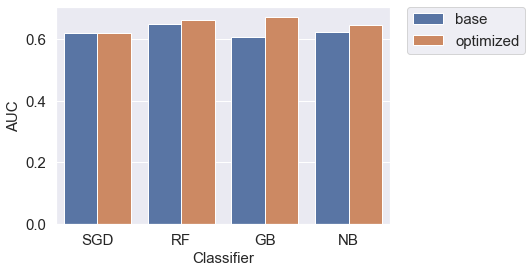

In [256]:
ax = sns.barplot(x="classifier", y="auc", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize=15)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)

plt.show()

In [218]:
pickle.dump(gbc_random.best_estimator_, open('best_classifier.pkl', 'wb'),protocol = 4)

In [220]:
X_test = df_test[cols].values
y_test = df_test['OUTPUT_LABEL'].values

scaler = pickle.load(open('scaler.sav', 'rb'))
X_test_tf = scaler.transform(X_test)

In [221]:
best_model = pickle.load(open('best_classifier.pkl','rb'))

In [222]:
y_train_preds = best_model.predict_proba(X_train_tf)[:,1]
y_valid_preds = best_model.predict_proba(X_valid_tf)[:,1]
y_test_preds = best_model.predict_proba(X_test_tf)[:,1]

In [223]:
thresh = 0.5

print('Training:')
train_auc, train_accuracy, train_recall, train_precision, train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
valid_auc, valid_accuracy, valid_recall, valid_precision, valid_specificity = print_report(y_valid,y_valid_preds, thresh)
print('Test:')
test_auc, test_accuracy, test_recall, test_precision, test_specificity = print_report(y_test,y_test_preds, thresh)

Training:
AUC:0.984
accuracy:0.933
recall:0.904
precision:0.959
specificity:0.961
prevalence:0.500
 
Validation:
AUC:0.670
accuracy:0.666
recall:0.588
precision:0.120
specificity:0.672
prevalence:0.070
 
Test:
AUC:0.676
accuracy:0.664
recall:0.584
precision:0.109
specificity:0.670
prevalence:0.065
 


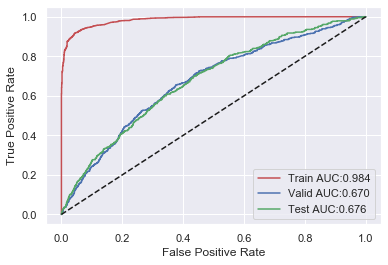

In [224]:
from sklearn.metrics import roc_curve 

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
auc_train = roc_auc_score(y_train, y_train_preds)

fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

plt.plot(fpr_train, tpr_train, 'r-',label ='Train AUC:%.3f'%auc_train)
plt.plot(fpr_valid, tpr_valid, 'b-',label ='Valid AUC:%.3f'%auc_valid)
plt.plot(fpr_test, tpr_test, 'g-',label ='Test AUC:%.3f'%auc_test)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()